In [1]:
import numpy as np
import cupy as cp
from scipy.linalg import inv
import matplotlib.pyplot as plt

## Kalman滤波器类, CPU版本

In [2]:
class KalmanFilterCPU:
    def __init__(self, A, B, H, Q, R, x0, P0):
        """
        初始化Kalman滤波器
        A: 状态转移矩阵
        B: 控制矩阵
        H: 观测矩阵
        Q: 过程噪声协方差矩阵
        R: 测量噪声协方差矩阵
        x0: 初始状态
        P0: 初始状态协方差矩阵
        """
        self.A = A
        self.B = B
        self.H = H
        self.Q = Q
        self.R = R
        self.x = x0
        self.P = P0

    def predict(self, u=None):
        """
        预测步骤
        u: 控制向量
        """
        if u is None:
            u = np.zeros((self.B.shape[1], 1))
        
        self.x = self.A @ self.x + self.B @ u
        self.P = self.A @ self.P @ self.A.T + self.Q

    def update(self, z):
        """
        更新步骤
        z: 测量值
        """
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ inv(S)
        
        self.x = self.x + K @ y
        self.P = self.P - K @ self.H @ self.P

    def get_state(self):
        """
        获取当前状态估计值
        """
        return self.x

## Kalman滤波器类, GPU版本

In [3]:
class KalmanFilterGPU:
    def __init__(self, A, B, H, Q, R, x0, P0):
        self.A = cp.asarray(A)
        self.B = cp.asarray(B)
        self.H = cp.asarray(H)
        self.Q = cp.asarray(Q)
        self.R = cp.asarray(R)
        self.x = cp.asarray(x0)
        self.P = cp.asarray(P0)

    def predict(self, u=None):
        if u is None:
            u = cp.zeros((self.B.shape[1], 1))
        self.x = self.A @ self.x + self.B @ u
        self.P = self.A @ self.P @ self.A.T + self.Q

    def update(self, z):
        z = cp.asarray(z)
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ cp.asarray(inv(cp.asnumpy(S)))
        self.x = self.x + K @ y
        self.P = self.P - K @ self.H @ self.P

    def get_state(self):
        return cp.asnumpy(self.x)

## 点的运动追踪

In [4]:
# 点的运动追踪
def track_objects(kalman_filter, detections, A, B, H, Q, R, x0, P0):
    kf = kalman_filter(A, B, H, Q, R, x0, P0)
    results = []
    for detection in detections:
        z = np.array(detection).reshape((2, 1))
        kf.predict()
        kf.update(z)
        state = kf.get_state()
        results.append(state.ravel().tolist())
    return results

多批次同时计算

In [5]:
def track_objects_batch(kalman_filter_class, detections, A, B, H, Q, R, x0, P0):
    kf_list = [kalman_filter_class(A, B, H, Q, R, x0, P0) for _ in range(detections.shape[1])]
    results = []

    for t in range(detections.shape[0]):
        batch_results = []
        for i, kf in enumerate(kf_list):
            z = detections[t, i].reshape((2, 1))
            kf.predict()
            kf.update(z)
            state = kf.get_state()
            batch_results.append(state.ravel().tolist())
        results.append(batch_results)

    results = np.array(results)
    return results

## 测试

init_states shape (8, 6, 1)
real shape (10, 8, 2)
predict shape (10, 8, 4)


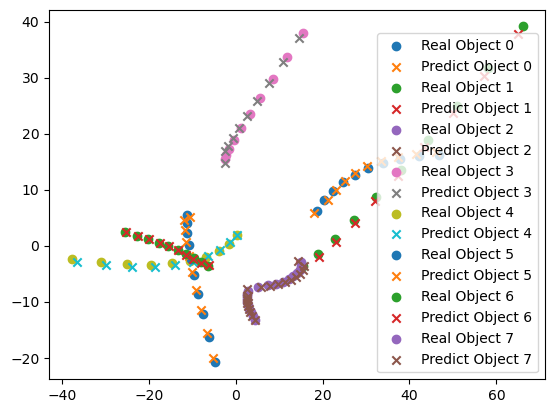

In [6]:
# 测试
# Initialization parameters
dt = 1
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
B = np.zeros((4, 1))
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])
Q = np.eye(4) * 0.01
R = np.eye(2) * 0.1
x0 = np.array([[0], [0], [0], [0]])
P0 = np.eye(4)

PTS = 8
TIMES = 10

############################################################################################

# Generate 10 random initial states
np.random.seed(0)
init_states = []
for i in range(PTS):
    x = np.random.randn(2, 1) * 10
    v = np.random.randn(2, 1)
    a = np.random.randn(2, 1)
    a = a / np.linalg.norm(a) * np.random.rand() * 1

    # Convert x, y, a to x, y, vx, vy, ax, ay
    init_states.append(np.vstack([x, v, a]))

# Convert to numpy array
init_states = np.array(init_states)
print('init_states shape', init_states.shape)


############################################################################################

# Update states for 10 time steps
real = []
for t in range(TIMES):
    updated_states = []
    for state in init_states:
        state[:2] += state[2:4] * dt + 0.5 * state[4:] * dt**2
        state[2:4] += state[4:] * dt
        updated_states.append(state[:2].reshape(2))
    real.append(np.array(updated_states))

# Convert to numpy array
real = np.array(real)

# Print the shape of the real states
print('real shape', real.shape)


############################################################################################


# 从上述计算后的结果中，选择第一组的点进行测试
# predict = track_objects(KalmanFilterGPU, real[:, 0], A, B, H, Q, R, x0, P0)

# 从上述计算后的结果中，进行批量预测
predict_batch = track_objects_batch(KalmanFilterGPU, real, A, B, H, Q, R, x0, P0)

# Print the shape of the predicted states
print('predict shape', predict_batch.shape)

# 使用散点图可视化结果
plt.figure()
for i in range(PTS):
    plt.scatter(real[:, i, 0], real[:, i, 1], label=f'Real Object {i}')
    plt.scatter(predict_batch[:, i, 0], predict_batch[:, i, 1], label=f'Predict Object {i}', marker='x')

plt.legend()
plt.show()